Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.0154


 v = 0.00000
Iteration 10000: Position (x, y) = (0.20, 0.08), Wall Distance = 0.08 m
Iteration 20000: Position (x, y) = (0.23, 0.06), Wall Distance = 0.04 m
Iteration 30000: Position (x, y) = (0.25, 0.06), Wall Distance = 0.02 m
Iteration 40000: Position (x, y) = (0.25, 0.04), Wall Distance = 0.02 m
Total simulation time: 17.58 seconds
Zigzag
0.1454
nan


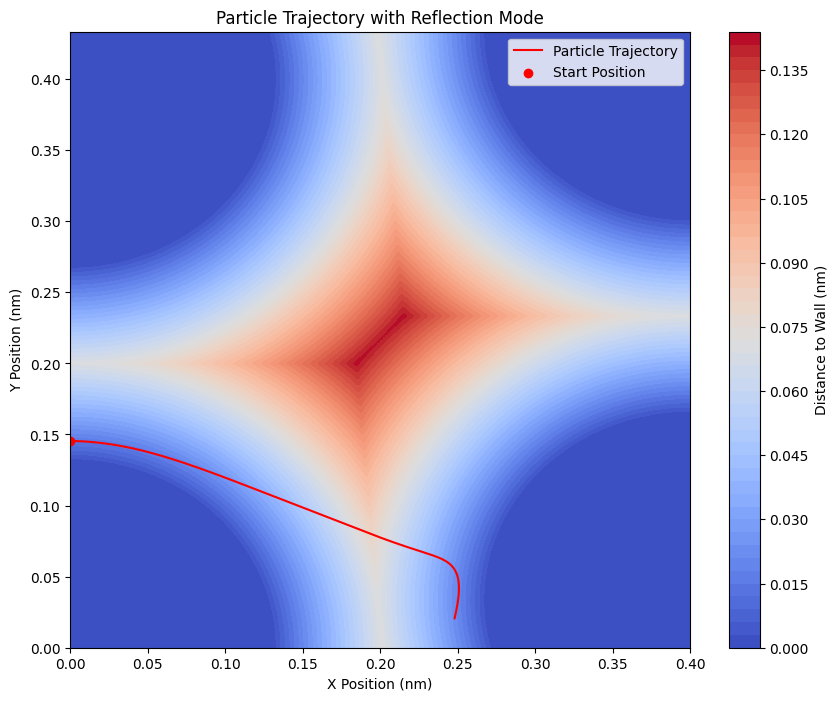

In [5]:
## particle trajectory > at first file position
# then radius  of the particle
# no iteration limit
# mode and plot at the output

##############################           ########################################


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

#/mnt/c/Users/mahir/vU_0.65_12.csv
#/mnt/c/Users/mahir/OneDrive/Desktop/Research/uioy/UPV_0.7_14
# Extract radius from the file path 
file_path = "/mnt/c/Users/mahir/vU_0.65_12.csv"
radius_match = re.search(r"vU_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.0001  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = 0, 0
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_traj.append(x_next)
    y_traj.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_traj[-2] > y_traj[-3]:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Particle Trajectory')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with Reflection Mode')
plt.show()
